## Investigating data through SQL queries

In [1]:
import sqlite3
from sklearn import metrics
from scipy.sparse import hstack
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm 
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
cnx = sqlite3.connect('DebateOrg/ddo-V1.db')
c = cnx.cursor()

In [3]:
#Total number of debates won by men
c.execute('SELECT count(users.number_of_won_debates) FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.gender="Male"')
results = c.fetchall()
results

[(25954,)]

In [4]:
#Total number of debates won by women
c.execute('SELECT count(users.number_of_won_debates) FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.gender="Female"')
results = c.fetchall()
results

[(7642,)]

In [5]:
#The total number of Conservatives and Liberals
c.execute('SELECT count(users.ideology) FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Conservative"')
results_con = c.fetchall()
c.execute('SELECT count(users.ideology) FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Liberal"')
results_lib = c.fetchall()


print(f"The toal number of conservatives is {results_con[0][0]} and the total number of liberals is {results_lib[0][0]}")

The toal number of conservatives is 6814 and the total number of liberals is 4340


In [6]:
#Conservatives users' favorite categories 
c.execute('SELECT count(users.url) as counts, users.gender, debates.category FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Conservative" GROUP BY category,users.gender')
c.fetchall()[:10]

[(11, 'Female', 'Arts'),
 (51, 'Male', 'Arts'),
 (12, 'Prefer not to say', 'Arts'),
 (1, 'Female', 'Cars'),
 (9, 'Male', 'Cars'),
 (6, 'Prefer not to say', 'Cars'),
 (7, 'Female', 'Economics'),
 (97, 'Male', 'Economics'),
 (47, 'Prefer not to say', 'Economics'),
 (46, 'Female', 'Education')]

In [7]:
#Liberal users' favorite categories 
c.execute('SELECT count(users.url) as counts, users.gender, debates.category FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Liberal" GROUP BY category,users.gender')
c.fetchall()[:10]

[(8, 'Female', 'Arts'),
 (29, 'Male', 'Arts'),
 (11, 'Prefer not to say', 'Arts'),
 (1, 'Female', 'Cars'),
 (2, 'Male', 'Cars'),
 (3, 'Prefer not to say', 'Cars'),
 (1, 'Androgyne', 'Economics'),
 (7, 'Female', 'Economics'),
 (38, 'Male', 'Economics'),
 (16, 'Prefer not to say', 'Economics')]

In [8]:
#Conservatives users' religion 
c.execute('SELECT count(users.url) as counts,users.gender, users.religion FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Conservative" GROUP BY users.gender,users.religion')
c.fetchall()[:10]

[(20, 'Female', 'Agnostic'),
 (3, 'Female', 'Atheist'),
 (186, 'Female', 'Christian'),
 (2, 'Female', 'Christian - Amish'),
 (1, 'Female', 'Christian - Assemblies of God'),
 (40, 'Female', 'Christian - Baptist'),
 (47, 'Female', 'Christian - Catholic'),
 (5, 'Female', 'Christian - Church of Christ'),
 (12, 'Female', 'Christian - Episcopalian'),
 (1, 'Female', 'Christian - Greek Orthodox')]

In [9]:
#Liberal users' religion 
c.execute('SELECT count(users.url) as counts, users.religion FROM debates LEFT JOIN users ON debates.participant_1_link=users.url WHERE users.ideology="Liberal" GROUP BY users.religion')
c.fetchall()[:10]

[(845, 'Agnostic'),
 (1225, 'Atheist'),
 (2, 'Bah��'),
 (43, 'Buddhist'),
 (1, 'Buddhist - Mahayana'),
 (2, 'Buddhist - Vajrayana'),
 (320, 'Christian'),
 (12, 'Christian - Amish'),
 (28, 'Christian - Anglican'),
 (2, 'Christian - Assemblies of God')]

### Data Cleaning and dataset pre-processing

In [10]:
#debates title with users and category
debates = pd.read_sql_query('SELECT participant_1_link,category,url,title, participant_1_position FROM debates ', cnx)
#users
users = pd.read_sql_query('SELECT * FROM users', cnx)
#selecting only the useful columns like party,religion, ethnicity etc
users=users[['url','ideology','party','gender','ethnicity','religion','win_ratio']]

#computing percentage of win
interval = re.compile('^(\d+\.\d+)\%$')

def read(elem):
    m=interval.search(elem)
    if m:
        num = float(m.group(1))
        return((num)/100)
users['win_ratio']=users['win_ratio'].apply(read)

#applying function to clean username
username = re.compile('^.(\w+).$')

def find_username(elem):
    m=username.search(str(elem))
    if m:
        un = m.group(1)
        return un
    
debates['username']=debates['participant_1_link'].apply(find_username)
users["url"]=users["url"].apply(find_username)

I decided to remove the values "Not Saying" to have a better representation of the classes

In [11]:
users=users[users["religion"]!="Not Saying"]
users=users[users["party"]!="Not Saying"]
users=users[users["ideology"]!="Not Saying"]
users=users[users["ethnicity"]!="Not Saying"]
users=users[users["gender"]!="Prefer not to say"]

The goal is to build a support vector machine model to predict to which groups people belong to, based on the title's debate.
The variables to predict are:

    1) Gender: Male, Female, LGBTQIAPK+;
    2) Ideology: Leftist, centric, Rightist, Other;
    3) Ethnicity: Asian,Black,East Indian,Latino,Middle Eastern,Native American,Other,Pacific Islander,White;   
    4) Religion: Agnostic, Atheist, Christian, Muslim, Other;

In [12]:
def groupping_gender(x):
    #gender
    if x in ("Agender","Androgyne","Bigender","Genderqueer","Transgender Female","Transgender Male"):
        x = "LGBTQIAPK+" 
    return x 
def groupping_ideol(x):    
    #ideology
    if x in ("Apathetic","Undecided","Other"):
        x="Other"
    elif x in ("Anarchist","Communist","Green","Socialist"):
        x="Left"
    elif x in ("Labor","Moderate","Progressive"):
        x="Center"
    else:
        x= "Right"
    return x

def groupping_religion(x):
    if x in ("Agnostic","Atheist"):
        x="Non Believer"
    elif x in ("Christian - Catholic", "Christian","Christian - Mennonite", "Christian - Amish","Christian - Episcopalian","Christian - Jehovah's Witness","Christian - Seventh-Day Adventist","Christian - Assemblies of God","Christian - Anglican","Christian - Greek Orthodox","Christian - Presbytarian","Christian - Pentecosta","Christian - Methodist","Christian - Church of Christ","Christian - Lutheran","Christian - Latter-Day Saints","Christian - Protestant","Christian - Baptist"):
        x="Christian"
    elif x in ("Muslim - Sufi","Muslim - Shiite","Islamic","Muslim - Sunni","Muslim"):
        x="Muslim"
    else:
        x="Other"
    return x

position = re.compile('^([A-Z][a-z]+)\s.(\w+).$')

def pos(elem):
    m=position.search(str(elem))
    if m:
        un = m.group(2)
        return un

In [13]:
users["religion"]=users["religion"].apply(groupping_religion)
users["gender"]=users["gender"].apply(groupping_gender)
users["ideology"]=users["ideology"].apply(groupping_ideol)


Text(0.5, 1.0, 'Religions')

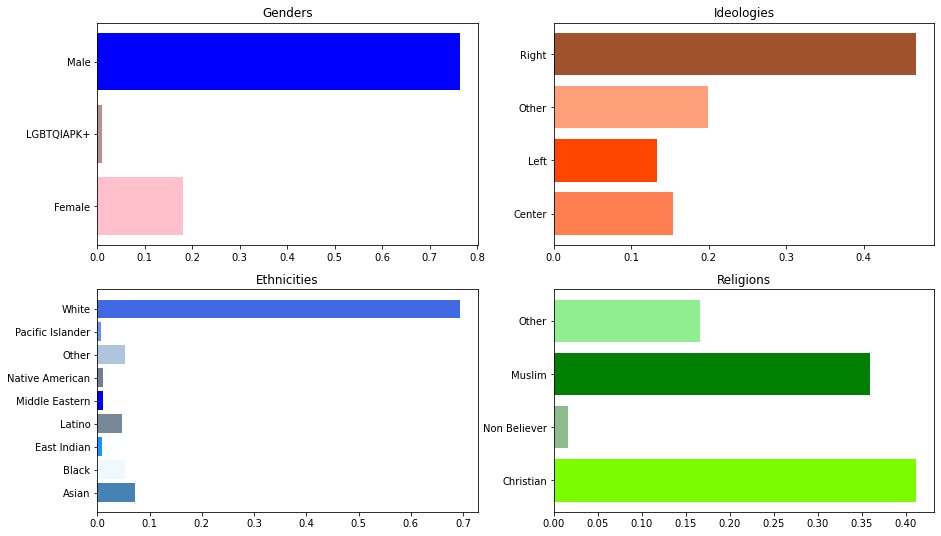

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,9))

#gender
gender=['Female','LGBTQIAPK+','Male']
gender_counts=np.array(users.groupby("gender")["url"].count())/len(users)
ax[0,0].barh(gender,gender_counts,color=['pink','rosybrown','blue'])
ax[0,0].set_title("Genders")

#ideology
_id=["Center", "Left","Other","Right"]
id_counts=np.array(users.groupby("ideology")["url"].count())/len(users)
ax[0,1].barh(_id,id_counts,color=['coral','orangered','lightsalmon','sienna'])
ax[0,1].set_title("Ideologies")

#ethinicity
etn=['Asian','Black','East Indian','Latino','Middle Eastern','Native American','Other','Pacific Islander','White']
etn_counts=np.array(users.groupby("ethnicity")["url"].count())/len(users)
ax[1,0].barh(etn,etn_counts,color=['steelblue','aliceblue','dodgerblue','lightslategray','blue','slategrey','lightsteelblue','cornflowerblue','royalblue'])
ax[1,0].set_title("Ethnicities")

#religion
rel=['Christian','Non Believer','Muslim','Other']
rel_counts=np.array(users.groupby("religion")["url"].count())/len(users)
ax[1,1].barh(rel,rel_counts,color=['lawngreen','darkseagreen','green','lightgreen'])
ax[1,1].set_title("Religions")

In [20]:
users=users.reset_index()
users=users[["url","ideology","party","gender","ethnicity","religion","win_ratio"]]

In [21]:
users

,url,ideology,party,gender,ethnicity,religion,win_ratio
0,Mikal,Right,Independent,Male,White,Non Believer,0.9684
1,bluesteel,Right,Republican Party,Female,White,Christian,0.9811
2,Kleptin,Other,Other,Male,Asian,Non Believer,0.9448
3,tejretics,Right,Democratic Party,Male,East Indian,Non Believer,0.9531
4,thett3,Right,Independent,Female,White,Christian,0.9133
...,...,...,...,...,...,...,...
4163,None,Left,American Nazi Party,Male,White,Christian,0.1587
4164,FanboyMctroll,Left,Pirate Party,Male,White,Non Believer,0.1379
4165,jp_porwisz10,Right,Republican Party,Male,White,Christian,0.0909
4166,hd1997,Other,Democratic Party,Female,White,Other,0.1667


In [22]:
#obtaining text from every debate

arguments=pd.read_sql_query('SELECT * FROM arguments',cnx)
arguments['user']=arguments['user'].apply(find_username)

In [23]:
arg=pd.merge(arguments,debates, left_on="debate",right_on="url", how="left")

In [24]:
arg.columns

Index(['debate', 'text', 'user', 'side', 'round_number', 'participant_1_link',
       'category', 'url', 'title', 'participant_1_position', 'username'],
      dtype='object')

In [25]:
arg_1=arg[['text', 'user','side','category', 'title']]

In [26]:
users.columns

Index(['url', 'ideology', 'party', 'gender', 'ethnicity', 'religion',
       'win_ratio'],
      dtype='object')

In [27]:
#creating a dataset with title-debate, text debate and characteristics per every user
arg_2=pd.merge(arg_1, users, left_on="user",right_on="url",how="left")


In [28]:
arg_2=arg_2.dropna().reset_index()

In [29]:
arg_2

,index,text,user,side,category,title,url,ideology,party,gender,ethnicity,religion,win_ratio
0,0,Some context on the resolution. Normally I wou...,Mikal,Pro,Miscellaneous,Covenys recent behavior would be a net detrime...,Mikal,Right,Independent,Male,White,Non Believer,0.9684
1,2,We can dismiss most everything in his last rou...,Mikal,Pro,Miscellaneous,Covenys recent behavior would be a net detrime...,Mikal,Right,Independent,Male,White,Non Believer,0.9684
2,4,On to rebuttals1) IntroI'm not sure what he is...,Mikal,Pro,Miscellaneous,Covenys recent behavior would be a net detrime...,Mikal,Right,Independent,Male,White,Non Believer,0.9684
3,6,This is a debate challenge to Cassie on a foru...,Mikal,Con,Politics,Islam is a civilized religion,Mikal,Right,Independent,Male,White,Non Believer,0.9684
4,8,Resending this to Zaro as this was intended fo...,Mikal,Con,Politics,Islam is a civilized religion,Mikal,Right,Independent,Male,White,Non Believer,0.9684
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94713,5908627,Don't dismiss my position as a non-argument. Y...,Mikegj1077,Con,Health,Gov. funded health care,Mikegj1077,Right,Republican Party,Male,White,Christian,0.0556
94714,5908629,"""UK - booming economy, Nationalized Health Ser...",Mikegj1077,Con,Health,Gov. funded health care,Mikegj1077,Right,Republican Party,Male,White,Christian,0.0556
94715,5912374,"Communism was terrible, It made people equally...",billsands,Pro,Politics,The USSR could have survived if it has adopted...,billsands,Left,Socialist Party,Male,Other,Non Believer,0.3125
94716,5912376,Where did i state marx was right about everyth...,billsands,Pro,Politics,The USSR could have survived if it has adopted...,billsands,Left,Socialist Party,Male,Other,Non Believer,0.3125


In [30]:
arg_2=arg_2[['text', 'user', 'side', 'category', 'title', 'url', 'ideology','party', 'gender', 'ethnicity', 'religion', 'win_ratio']]

In [31]:
arg_2.to_csv("non_tokenized.csv")

### Text Preprocessing

Tokenization: breaking a stream of text up into words, phrases, symbols, or other meaningful elements called tokens. The list of tokens becomes input for further processing.NLTK Library has word_tokenize and sent_tokenize to easily break a stream of text into a list of words or sentences, respectively.

Word Stemming/Lemmatization: The aim of both processes is the same, reducing the inflectional forms of each word into a common base or root. Lemmatization is closely related to stemming. The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster, and the reduced accuracy may not matter for some applications.
#### Title


In [32]:
#Pre processing text
# Step - a : Remove blank rows if any.
arg_2['title'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
arg_2['title'] = [entry.lower() for entry in arg_2['title']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
arg_2['title']= [word_tokenize(entry) for entry in arg_2['title']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(arg_2['title']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        #print(word,tag)
        ## Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'title_final'
    arg_2.loc[index,'title_final'] = str(Final_words)

#### Text Debate

In [33]:
# Step - a : Remove blank rows if any.
arg_2['text'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
arg_2['text'] = [entry.lower() for entry in arg_2['text']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
arg_2['text']= [word_tokenize(entry) for entry in arg_2['text']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(arg_2['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'title_final'
    arg_2.loc[index,'text_final'] = str(Final_words)

In [34]:
#saving in a csv format for further use -i.e. SVM implementation
arg_2.to_csv("tokenized.csv")